In [ ]:
# default_exp image_blending

# Image Blending

# Task 5: Image blending in gradient area
> whatisit

Implementujte techniku bezešvého skládání obrazů v gradientní oblasti. Pro výpočet výsledného lineárního systému použijte iterativní metodu Gauss-Seidel. Demonstrujte funkčnost výsledné implementace na příkladě složení dvou snímků se znatelně odlišnou úrovní expozice.

In [ ]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from dzotools.utils import imgload, arr2img
from IPython.display import clear_output

background = imgload('data/blending/windows_normal.png', convert="L") / 256.0
foreground = imgload('data/blending/windows_dark.png', convert="L") / 256.0

# Load the mask and binarize it to 0, 1 and invert
mask = imgload('data/blending/windows_mask.png', convert="L")
mask = 1 - np.round(mask / 256).astype(int)

### Sparse Matrix
In order to save space (the $A$ matrix could be actually $n^4$ large where $n$ is the image width) we will implement our own sparse matrix implementation along with a numpy dot product.

In [ ]:
# exports
class SparseMatrix:
    def __init__(self, heigth, width):
        self.heigth, self.width = heigth, width
        
        # Working memory to speed up reallocation
        self.out = np.zeros(width, dtype="float32")        
        self.rows = {
            r: {} for r in range(heigth)
        }
        
    @property
    def shape(self):
        return (self.heigth, self.width)
        
    def __getitem__(self, location):
        """Get the value or default to zero."""
        y, x = location
        
        return self.rows[y].get(x, 0)
    
    def __setitem__(self, location, value):
        """Set the value in a sparse format."""
        y, x = location
        
        row = self.rows[y]
        if x in row and row[x] != value:
            print(f"Overwriting row/col {y}/{x} value from {row[x]} to {value}!")
        
        self.rows[y][x] = value
        
    __array_priority__ = 10000
        
    def __mul__(self, x: np.array) -> np.array:
        """Multiplication with a numpy array. Could perhaps be faster?"""
        self.out = np.zeros_like(self.out, dtype="float32")
        for y, row in self.rows.items():            
            k = np.fromiter(row.keys(), dtype="int32")
            v = np.fromiter(row.values(), dtype="float32")
            self.out[y] = np.dot(x.take(k), v)
            
        return self.out

In [ ]:
s = SparseMatrix(2, 2)
s[0, 0] = 2

assert s[0, 0] == 2
assert s[1, 1] == 0

assert s.shape == (2, 2)

np.testing.assert_array_equal(
    s * np.array([1, 1]), 
    np.array([2., 0.])
)

### NDArray Edge Wrapping

In [ ]:
class WrappedNdArray:
    """Wraps an ndarray and only returns value if within bounds."""
    def __init__(self, array: np.ndarray):
        assert len(array.shape) == 2, \
            "Only 2D arrays are supported."
        self.array = array
        
    def __getitem__(self, location):
        if 0 <= location[0] < self.array.shape[0] and 0 <= location[1] < self.array.shape[1]:
            return self.array[location]
        return 0
        
    def __setitem__(self, location, value):
        if 0 <= location[0] < self.array.shape[0] and 0 <= location[1] < self.array.shape[1]:
            self.array[location] = value

In [ ]:
arr = np.array([[1, 2, 3], [2, 3, 4]])
wrapped = WrappedNdArray(arr)
assert wrapped[10, 0] == 0

### Initialize the matrixes
Initialize the sparse matrix $A$, and vectors $b$ and $x$ (also called $I$ in lecture notes). The target vector $x$ is initialized as zeros.

In [ ]:
def prepare_data(mask, foreground, background):
    h, w = mask.shape
    pixel_count = w * h
    
    A = SparseMatrix(pixel_count, pixel_count)
    b = np.zeros_like(mask, dtype="float32")
    
    _foreground = WrappedNdArray(foreground)
    _background = WrappedNdArray(background)
    _A = WrappedNdArray(A)
    
    for y in range(h):
        for x in range(w):
            px = y * w + x
            
            if mask[y, x] > 0.5:
                _A[px, px] = 4
                _A[px, px-1] = -1
                _A[px, px+1] = -1
                _A[px-1, px] = -1
                _A[px+1, px] = -1
                b[y, x] = sum([
                    _foreground[y, x] - _foreground[y+1, x],
                    _foreground[y, x] - _foreground[y-1, x],
                    _foreground[y, x] - _foreground[y, x+1],
                    _foreground[y, x] - _foreground[y, x-1]
                ])
            else:
                _A[px, px] = 1
                b[y, x] = _background[y, x]
                
    return A, b

In [ ]:
A, b = prepare_data(mask, foreground, background)

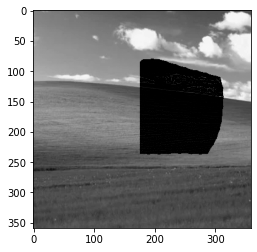

In [ ]:
b_reshaped = np.reshape(b, mask.shape)
plt.imshow(b_reshaped, vmin=0, vmax=1, cmap='gray')
plt.show()

### Gauss-Seidel Update

In [ ]:
ox = WrappedNdArray(background)
w, h = mask.shape

for step in trange(1000):
    clear_output(wait=True)
    nx = np.empty_like(b)
    
    for y in range(h):
        for x in range(w):
            nx[y, x] = 0.25*(ox[y-1, x] + ox[y+1, x] + ox[y, x-1] + ox[y, x+1] - b[y, x])
    
    ox.array = nx
    
    img = np.reshape(nx, mask.shape)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    plt.show()

  6%|▌         | 58/1000 [01:10<18:58,  1.21s/it]


KeyboardInterrupt: 

### Conjugate Gradient Update

In [ ]:
def conjugate_gradient_update(A, x, b, mult=1):
    grad = b - A*x
    alpha = np.linalg.norm(grad)/(grad@(A*grad))
    return x + (alpha * mult) * grad

In [ ]:
from IPython.display import clear_output

results = {}
x = foreground.flatten()

for step in trange(100):
    clear_output(wait=True)
    x = conjugate_gradient_update(A, x, b)
    
    # Show the image in the Jupyter Notebook
    img = np.reshape(x, mask.shape)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    plt.show()

 60%|██████    | 60/100 [01:49<01:13,  1.83s/it]


KeyboardInterrupt: 